# signals

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(pd.Series.vbt.signals.empty(5, index=index))
print(pd.DataFrame.vbt.signals.empty((5, 3), index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.empty((1000, 1000))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
204 µs ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
print(pd.Series.vbt.signals.random(5, 2, every_nth=2, seed=42, index=index))
print(pd.DataFrame.vbt.signals.random((5, 3), 2, every_nth=2, seed=42, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.random((1000, 1000), 100, every_nth=2)

entries = pd.DataFrame.vbt.signals.random((5, 3), 2, every_nth=2, seed=42, index=index, columns=columns)
big_entries = pd.DataFrame.vbt.signals.random((1000, 1000), 100, every_nth=2, index=big_ts.index)

2018-01-01     True
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05   True  False   True
3.67 ms ± 852 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
@njit
def choice_func_nb(col, from_range):
    # Select number of signals dynamically
    return np.random.choice(from_range, size=min(len(from_range), col+1), replace=False)

print(pd.DataFrame.vbt.signals.random_by_func((5, 3), choice_func_nb, seed=42, columns=columns))

%timeit pd.DataFrame.vbt.signals.random_by_func((1000, 1000), choice_func_nb, seed=42)

       a      b      c
0  False  False   True
1  False  False  False
2  False  False   True
3   True   True  False
4  False   True   True
8.77 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(entries.vbt.signals.random_exits(1, seed=42))

%timeit big_entries.vbt.signals.random_exits(1, seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True   True
2018-01-03  False  False  False
2018-01-04   True  False  False
2018-01-05  False   True  False
74.5 ms ± 633 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
print(entries.vbt.signals.random_exits_by_func(choice_func_nb, seed=42))

%timeit big_entries.vbt.signals.random_exits_by_func(choice_func_nb, seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True   True
2018-01-03  False  False   True
2018-01-04   True   True   True
2018-01-05  False   True  False
83.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
a = np.random.randint(-1, 2, size=(5, 3))
print(a)

[[ 0  1  0]
 [ 0  1 -1]
 [ 0  1  1]
 [ 1  1 -1]
 [ 1 -1 -1]]


In [11]:
big_a = np.random.randint(-1, 2, size=(1000, 1000))
big_a.shape

(1000, 1000)

In [12]:
@njit
def entry_func_nb(exits, col_idx, prev_idx, next_idx, a):
    # First value after last entry
    entries = np.full(exits.shape, False, dtype=b1)
    entries[a[:, col_idx] > 0] = True
    return entries

@njit
def exit_func_nb(entries, col_idx, prev_idx, next_idx, a):
    # First value after last exit
    exits = np.full(entries.shape, False, dtype=b1)
    exits[a[:, col_idx] < 0] = True
    return exits

print(pd.DataFrame.vbt.signals.entries_and_exits(a.shape, entry_func_nb, exit_func_nb, a, index=index, columns=columns))
%timeit pd.DataFrame.vbt.signals.entries_and_exits(big_a.shape, entry_func_nb, exit_func_nb, big_a)

(                a      b      c
2018-01-01  False   True  False
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04   True  False  False
2018-01-05  False  False  False,                 a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False   True
2018-01-05  False   True  False)
1.4 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
from numba import njit, b1

@njit
def exit_func_nb(entries, col_idx, prev_idx, next_idx):
    # First value after entry
    exit_mask = np.full(entries.shape, False, dtype=b1)
    exit_mask[prev_idx+1:next_idx] = True
    return exit_mask

print(entries.vbt.signals.exits(exit_func_nb))
%timeit big_entries.vbt.signals.exits(exit_func_nb)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
162 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print(entries.vbt.signals.exits(exit_func_nb, only_first=False))
%timeit big_entries.vbt.signals.exits(exit_func_nb, only_first=False)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03   True  False   True
2018-01-04   True   True   True
2018-01-05  False   True  False
165 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
e = pd.Series([True, False, False, False, False, False])
t = pd.Series([2, 3, 4, 3, 2, 1]).astype(np.float64)
print(e.vbt.signals.stop_loss_exits(t, 0.1))
print(e.vbt.signals.stop_loss_exits(t, 3., relative=False))
print(e.vbt.signals.stop_loss_exits(t, 0.1, trailing=True))
print(e.vbt.signals.stop_loss_exits(t, 0.1, trailing=True, only_first=False))

0    False
1    False
2    False
3    False
4    False
5     True
Name: 0, dtype: bool
0    False
1    False
2    False
3    False
4     True
5    False
Name: 0, dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
Name: 0, dtype: bool
0    False
1    False
2    False
3     True
4     True
5     True
Name: 0, dtype: bool


In [16]:
print(entries['a'].vbt.signals.stop_loss_exits(ts['a'], 0.1))
%timeit big_entries.iloc[:, 0].vbt.signals.stop_loss_exits(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.stop_loss_exits(ts['a'], 0.1))
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.stop_loss_exits(ts, 0.1))
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, 0.1)

print(entries.vbt.signals.stop_loss_exits(ts, [0.1, 0.5])) # test frame-wise stops
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, np.arange(0, 1, 0.1))

print(entries.vbt.signals.stop_loss_exits(ts, np.random.uniform(size=(2, 5, 3)))) # test element-wise stops
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, np.random.uniform(size=(10, 1000, 1000)))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool
3.33 ms ± 43.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
403 ms ± 8.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
464 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
stop_loss     0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False   Tru

In [17]:
print(entries['a'].vbt.signals.stop_loss_exits(ts['a'], 0.1, trailing=True))
%timeit big_entries.iloc[:, 0].vbt.signals.stop_loss_exits(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.stop_loss_exits(ts['a'], 0.1, trailing=True))
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.stop_loss_exits(ts, 0.1, trailing=True))
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, 0.1, trailing=True)

print(entries.vbt.signals.stop_loss_exits(ts, [0.1, 0.5], trailing=True)) # test frame-wise stops
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, np.arange(0, 1, 0.1), trailing=True)

print(entries.vbt.signals.stop_loss_exits(ts, np.random.uniform(size=(2, 5, 3)), trailing=True)) # test element-wise stops
%timeit big_entries.vbt.signals.stop_loss_exits(big_ts, np.random.uniform(size=(10, 1000, 1000)), trailing=True)

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool
3.17 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
393 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
473 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
trail_stop    0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False   Tr

In [18]:
print(entries & (ts > 1))
%timeit big_entries & (big_ts > 1)

print(entries.vbt.signals.AND(ts.values > 1))
%timeit big_entries.vbt.signals.AND(big_ts.values > 1)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False
294 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in greater



1.72 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
print(entries.vbt.signals.AND(ts > 1, ts > 2, ts > 3, ts > 4, ts > 5)) # you can pass multiple arguments
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3, ts > 4, ts > 5))
print(entries.vbt.signals.XOR(ts > 1, ts > 2, ts > 3, ts > 4, ts > 5))

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
               a      b      c
2018-01-01  True   True   True
2018-01-02  True   True   True
2018-01-03  True   True  False
2018-01-04  True   True   True
2018-01-05  True  False   True
                a      b      c
2018-01-01   True   True   True
2018-01-02   True   True   True
2018-01-03  False   True  False
2018-01-04   True   True   True
2018-01-05   True  False   True


In [20]:
print(entries.vbt.signals.num_signals)
%timeit big_entries.vbt.signals.num_signals # cached

a    2
b    2
c    2
dtype: int64
695 ns ± 11.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
print(entries.vbt.signals.avg_distance)
%timeit big_entries.vbt.signals.avg_distance # cached

a    4.0
b    2.0
c    4.0
dtype: float64
690 ns ± 8.93 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
diff_map_nb = njit(lambda col, a_prev, a_next: a_next - a_prev)
avg_reduce_nb = njit(lambda result: np.nanmean(result))

print(entries.vbt.signals.map_reduce_between(map_func_nb=diff_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(map_func_nb=diff_map_nb, reduce_func_nb=avg_reduce_nb)

a    4.0
b    2.0
c    4.0
dtype: float64
3.73 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(entries.vbt.signals.map_reduce_between(
    other=entries.vbt.signals.fshift(1), 
    map_func_nb=diff_map_nb, 
    reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(\
    other=big_entries.vbt.signals.fshift(1),\
    map_func_nb=diff_map_nb,\
    reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    1.0
dtype: float64
57 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print(entries.vbt.signals.shuffle(seed=42))
%timeit big_entries.vbt.signals.shuffle(seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True  False   True
2018-01-03  False   True  False
2018-01-04   True   True   True
2018-01-05  False  False  False
16 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(entries.vbt.signals.fshift(2))
%timeit big_entries.vbt.signals.fshift(2)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
1.62 ms ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
print(entries.vbt.signals.rank())
%timeit big_entries.vbt.signals.rank()

print(entries.vbt.signals.rank(after_false=True))
%timeit big_entries.vbt.signals.rank(after_false=True)

print(entries.vbt.signals.rank(allow_gaps=True))
%timeit big_entries.vbt.signals.rank(allow_gaps=True)

reset_entries = entries.vbt.signals.fshift(1)
big_reset_entries = big_entries.vbt.signals.fshift(1)

print(entries.vbt.signals.rank(allow_gaps=True, reset_signals=reset_entries))
%timeit big_entries.vbt.signals.rank(allow_gaps=True, reset_signals=big_reset_entries)

            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  0
2018-01-03  0  1  0
2018-01-04  0  0  0
2018-01-05  1  0  1
4.21 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
            a  b  c
2018-01-01  0  0  0
2018-01-02  0  0  0
2018-01-03  0  1  0
2018-01-04  0  0  0
2018-01-05  1  0  1
4.1 ms ± 81.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  0
2018-01-03  0  2  0
2018-01-04  0  0  0
2018-01-05  2  0  2
3.9 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  0
2018-01-03  0  1  0
2018-01-04  0  0  0
2018-01-05  1  0  1
6 ms ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
print(entries.vbt.signals.first())
%timeit big_entries.vbt.signals.first()

print(entries.vbt.signals.nst(2, allow_gaps=True))
%timeit big_entries.vbt.signals.nst(2, allow_gaps=True)

print(entries.vbt.signals.from_nst(2, allow_gaps=True))
%timeit big_entries.vbt.signals.from_nst(2, allow_gaps=True)

                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05   True  False   True
5.15 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05   True  False   True
5 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05   True  False   True
5 ms ± 34.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


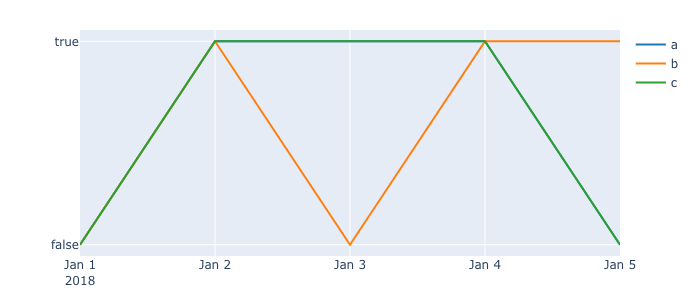

In [28]:
entries.vbt.signals.plot().show_png()

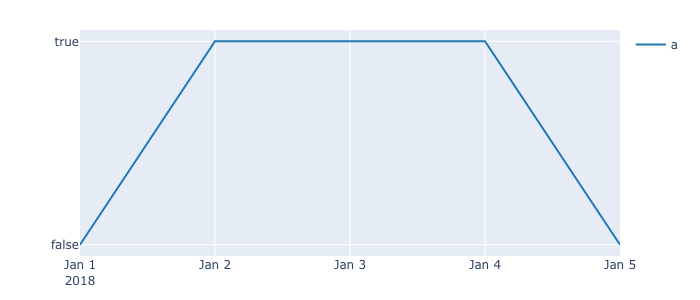

In [29]:
entries['a'].vbt.signals.plot().show_png()

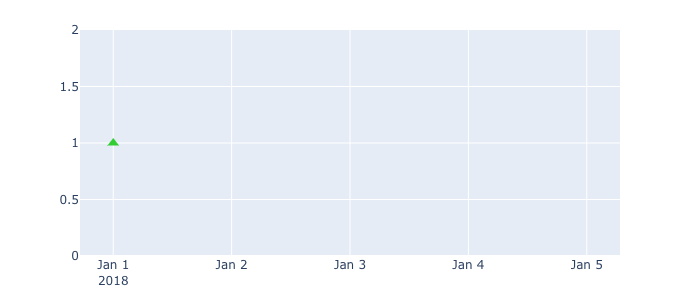

In [30]:
entries['a'].vbt.signals.plot_markers(ts['a'], signal_type='entry').show_png()

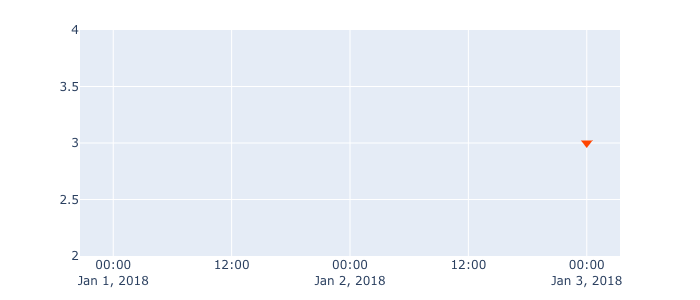

In [31]:
entries['b'].vbt.signals.plot_markers(ts['b'], signal_type='exit').show_png()